In [1]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/Bayesian-Filtering-and-Smoothing


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Tuple

In [3]:
from regression.linear_regression import *

In [4]:
from mcmc.utils.mcmc_utils import *

# Linear Gaussian Regression

## Generate Data

In [5]:
noise_std = 1e-1
true_theta_1 = 1.0
true_theta_2 = 0.7
dataset = generate_RegressionDataSet(
    num_data=50, 
    theta_1=true_theta_1, 
    theta_2=true_theta_2, 
    noise_std=noise_std)

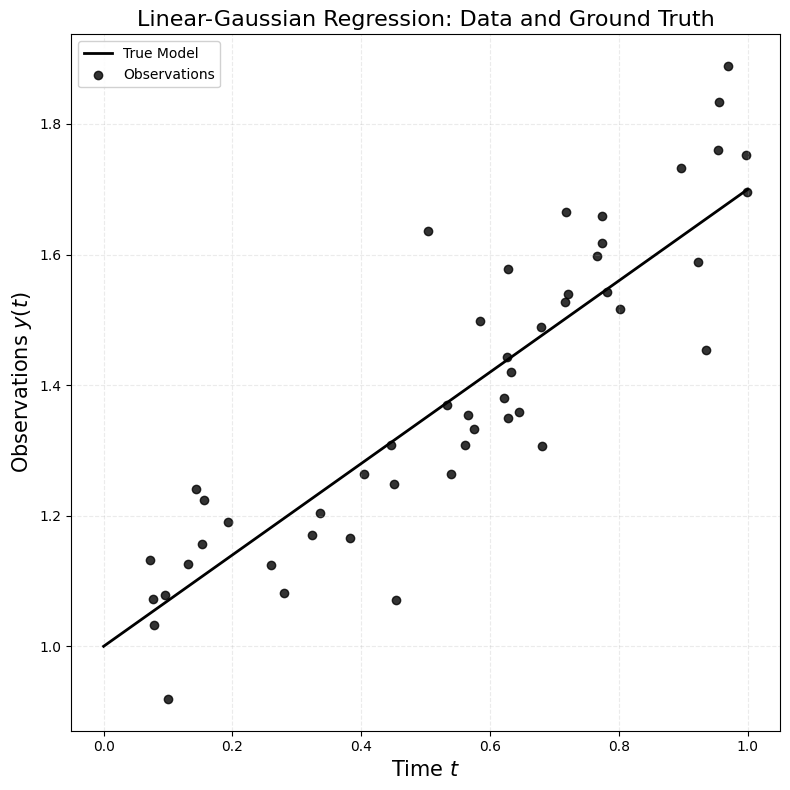

In [6]:
fig = plt.figure(1, figsize=(8,8))

plt.plot(
    dataset.t_plot, 
    dataset.y_true, 
    linestyle="-", 
    color="black", 
    linewidth=2, 
    label='True Model')

plt.scatter(
    dataset.t, 
    dataset.y, 
    color = "black",
    alpha = 0.8,
    label="Observations")

plt.xlabel(r"Time $t$", fontsize=15)
plt.ylabel(r"Observations $y(t)$", fontsize=15)

plt.title(
    "Linear-Gaussian Regression: Data and Ground Truth",
    fontsize=16
)

plt.legend(
    loc="best",
    frameon=True,
    framealpha=0.9
)

plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()
plt.close(fig)

## Prior on model parameters

We place independent standard Gaussian priors on the regression parameters
$\theta_1$ (intercept) and $\theta_2$ (slope):

$$
\theta_1 \sim \mathcal{N}(0, 1), \qquad
\theta_2 \sim \mathcal{N}(0, 1).
$$

Equivalently, the parameter vector

$$
\boldsymbol{\theta} =
\begin{bmatrix}
\theta_1 \\
\theta_2
\end{bmatrix}
$$

is assigned a multivariate Gaussian prior

$$
\boldsymbol{\theta} \sim \mathcal{N}(\boldsymbol{\mu}_0, \mathbf{C}_0),
$$

with

$$
\boldsymbol{\mu}_0 =
\begin{bmatrix}
0 \\
0
\end{bmatrix},
\qquad
\mathbf{C}_0 =
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}.
$$


<Figure size 640x480 with 0 Axes>

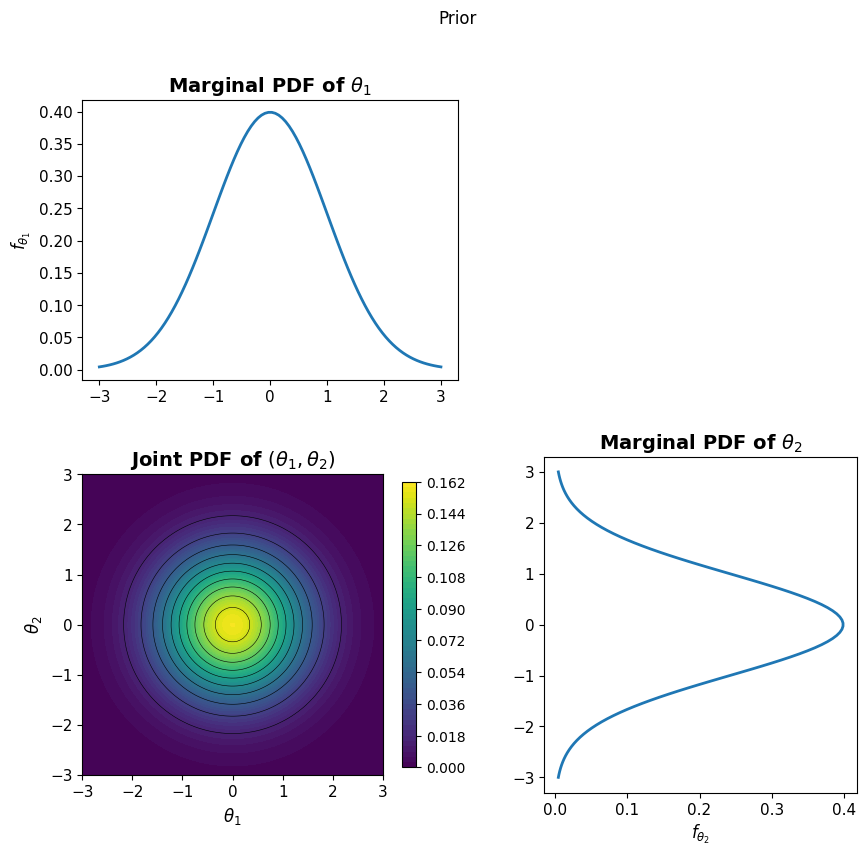

In [7]:
# Prior on parameters
mu_0 = np.zeros(2)          # Prior Mean of theta
C_0 = np.eye(2)             # Prior Co-variance of theta

offset_range = np.linspace(-3, 3,100)
slope_range = np.linspace(-3, 3,100)

plt.close("all")
plt.figure(1)
figp, axsp = plot_bivariate_gauss(offset_range, slope_range, mu_0, C_0)
plt.suptitle('Prior')
plt.show()

## Prior Predictive Distribution

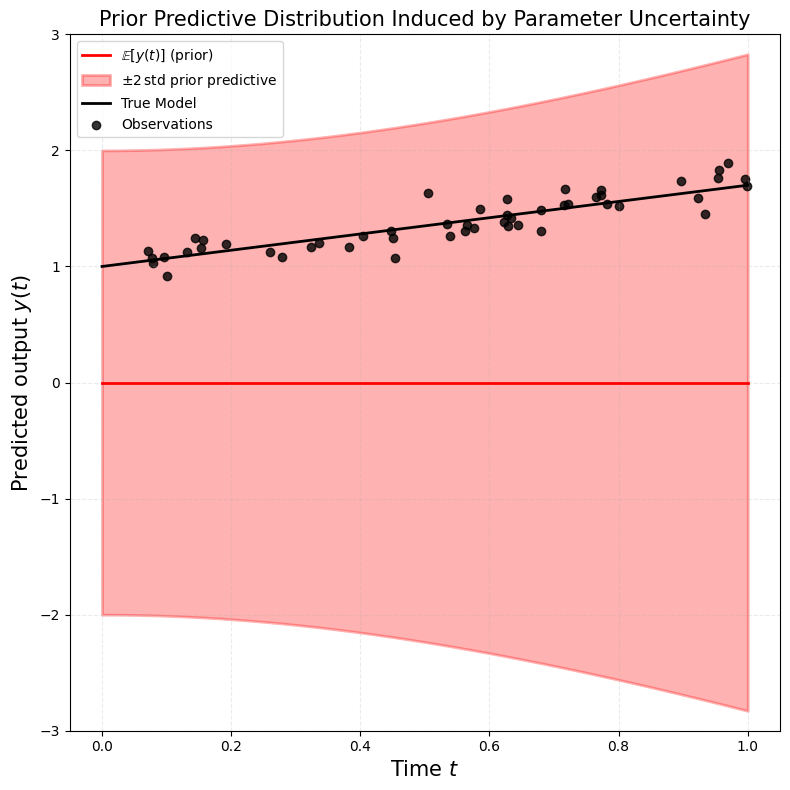

In [8]:
# Plotting Grid
t_plot = dataset.t_plot     # shape (m,)
m = t_plot.shape[0]

# Design matrix H_p for plotting points
H_p = np.column_stack([
    np.ones_like(t_plot), t_plot
    ])                      # shape (m, 2)


# Prior Predictive mean
prior_mean = H_p @ mu_0       # shape (m,)

# Prior Predictive Covariance
prior_co_var = H_p @ C_0 @ H_p.T # shape (m,m)

# Prior Predictive Variance
prior_var = np.diag(prior_co_var) # shape (m,)
prior_std = np.sqrt(prior_var)

# Plot
fig = plt.figure(figsize=(8, 8))

plt.plot(
    t_plot,
    prior_mean,
    color="red",
    linewidth=2,
    label=r"$\mathbb{E}[y(t)]$ (prior)"
)

plt.fill_between(
    t_plot,
    prior_mean - 2 * prior_std,
    prior_mean + 2 * prior_std,
    color="red",
    linewidth=2,
    alpha=0.3,
    label=r"$\pm 2\,\mathrm{std}$ prior predictive"
)

plt.plot(
    dataset.t_plot, 
    dataset.y_true, 
    linestyle="-", 
    color="black", 
    linewidth=2, 
    label='True Model')

plt.scatter(
    dataset.t, 
    dataset.y, 
    color = "black",
    alpha = 0.8,
    label="Observations")

plt.xlabel(r"Time $t$", fontsize=15)
plt.ylabel(r"Predicted output $y(t)$", fontsize=15)
plt.ylim([-3,3])
plt.title("Prior Predictive Distribution Induced by Parameter Uncertainty", fontsize=15)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()

plt.show()
plt.close(fig)

## Posterior Distribution

In [9]:
t = dataset.t   # shape (n,)
y = dataset.y   # shape (n,)
n = t.shape[0]


# Design matrix H for Observation points
H = np.column_stack([
    np.ones_like(t), t
    ])                      # shape (m, 2)

mu_post, C_post = batch_linear_gaussian_update(
    y=y, 
    H=H, 
    mu_0=mu_0, 
    C_0=C_0, 
    noise_std=noise_std)

In [10]:
print("posterior mean = ", mu_post)
print("prosterior Co-Variance = ", C_post)

posterior mean =  [0.97938489 0.74541113]
prosterior Co-Variance =  [[ 0.00095059 -0.00137913]
 [-0.00137913  0.00253387]]


<Figure size 640x480 with 0 Axes>

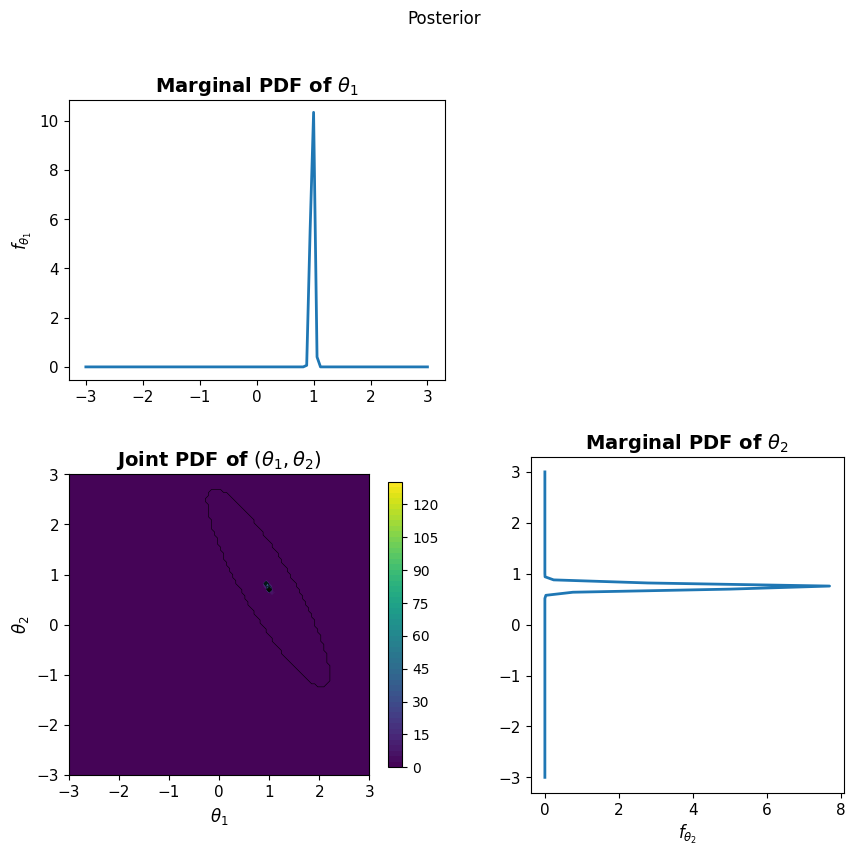

In [11]:
# Posterior on parameters

offset_range = np.linspace(-3, 3,100)
slope_range = np.linspace(-3, 3,100)

plt.close("all")
plt.figure(2)
figp, axsp = plot_bivariate_gauss(offset_range, slope_range, mu_post, C_post)
plt.suptitle('Posterior')
plt.show()

## Posterior Predictive Distribution

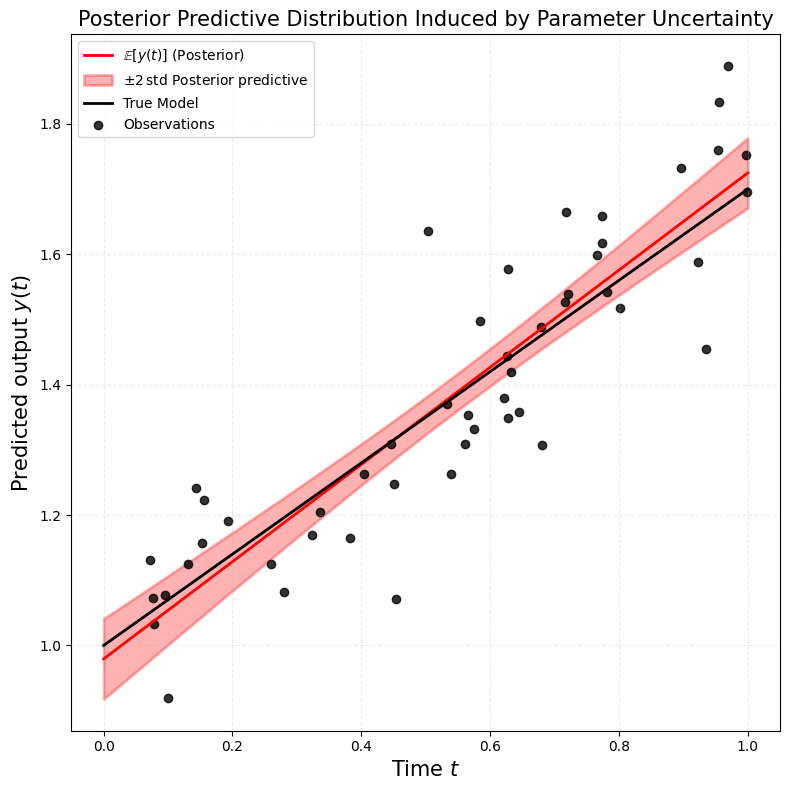

In [12]:
# Plotting Grid
t_plot = dataset.t_plot     # shape (m,)
m = t_plot.shape[0]

# Design matrix H_p for plotting points
H_p = np.column_stack([
    np.ones_like(t_plot), t_plot
    ])                      # shape (m, 2)


# Posterior Predictive mean
posterior_mean = H_p @ mu_post       # shape (m,)

# Posterior Predictive Covariance
prosterior_co_var = H_p @ C_post @ H_p.T # shape (m,m)

# Posterior Predictive Variance
Posterior_var = np.diag(prosterior_co_var) # shape (m,)
Posterior_std = np.sqrt(Posterior_var)

# Plot
fig = plt.figure(figsize=(8, 8))

plt.plot(
    t_plot,
    posterior_mean,
    color="red",
    linewidth=2,
    label=r"$\mathbb{E}[y(t)]$ (Posterior)"
)

plt.fill_between(
    t_plot,
    posterior_mean - 2 * Posterior_std,
    posterior_mean + 2 * Posterior_std,
    color="red",
    linewidth=2,
    alpha=0.3,
    label=r"$\pm 2\,\mathrm{std}$ Posterior predictive"
)

plt.plot(
    dataset.t_plot, 
    dataset.y_true, 
    linestyle="-", 
    color="black", 
    linewidth=2, 
    label='True Model')

plt.scatter(
    dataset.t, 
    dataset.y, 
    color = "black",
    alpha = 0.8,
    label="Observations")

plt.xlabel(r"Time $t$", fontsize=15)
plt.ylabel(r"Predicted output $y(t)$", fontsize=15)
plt.title("Posterior Predictive Distribution Induced by Parameter Uncertainty", fontsize=15)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()

plt.show()
plt.close(fig)

## Recursive Linear Regression 